# 🛰️ Aerial Landscape Classification with Deep Learning

This notebook demonstrates an end-to-end deep learning approach for classifying aerial landscapes using the **Skyview** dataset.

## 📊 Dataset Overview

The **Skyview Multi-Landscape Aerial Imagery Dataset** is a comprehensive collection featuring 15 distinct landscape categories captured from an aerial perspective:

* 🌾 Agriculture
* ✈️ Airport
* 🏖️ Beach
* 🌆 City
* 🏜️ Desert
* 🌲 Forest
* 🌿 Grassland
* 🛣️ Highway
* 🌊 Lake
* 🏔️ Mountain
* 🅿️ Parking
* ⚓ Port
* 🚆 Railway
* 🏘️ Residential
* 🏞️ River

**Dataset Specifications:**

* 🖼️ 12,000 total images (800 per category)
* 📐 Uniform 256×256 pixel resolution
* 📚 Derived from public AID and NWPU-Resisc45 datasets

## 🧠 Our Approach

This notebook implements:

1. 🗂️ **Data Preparation**: Creating an organized train/validation split (80%/20%)
2. 🔁 **Transfer Learning**: Leveraging a pre-trained ResNet18 model adapted for our specific task
3. 🏋️ **Model Training**: Implementing early stopping and best model checkpointing
4. 📈 **Performance Visualization**: Tracking loss metrics and evaluating predictions

The model will learn to distinguish between different types of landscapes as seen from above, which has practical applications in remote sensing, urban planning, environmental monitoring, and geographic information systems.


In [1]:
import numpy as np
import pandas as pd
import torch
import os, shutil, random
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch import nn, optim

## **Preparing Dataset**

In [2]:
image_directory = "/kaggle/input/skyview-an-aerial-landscape-dataset/Aerial_Landscapes"
output_dir = "/kaggle/working/data"
train_ratio = 0.8

for split in ["train", "val"]:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

### **Sample Images**

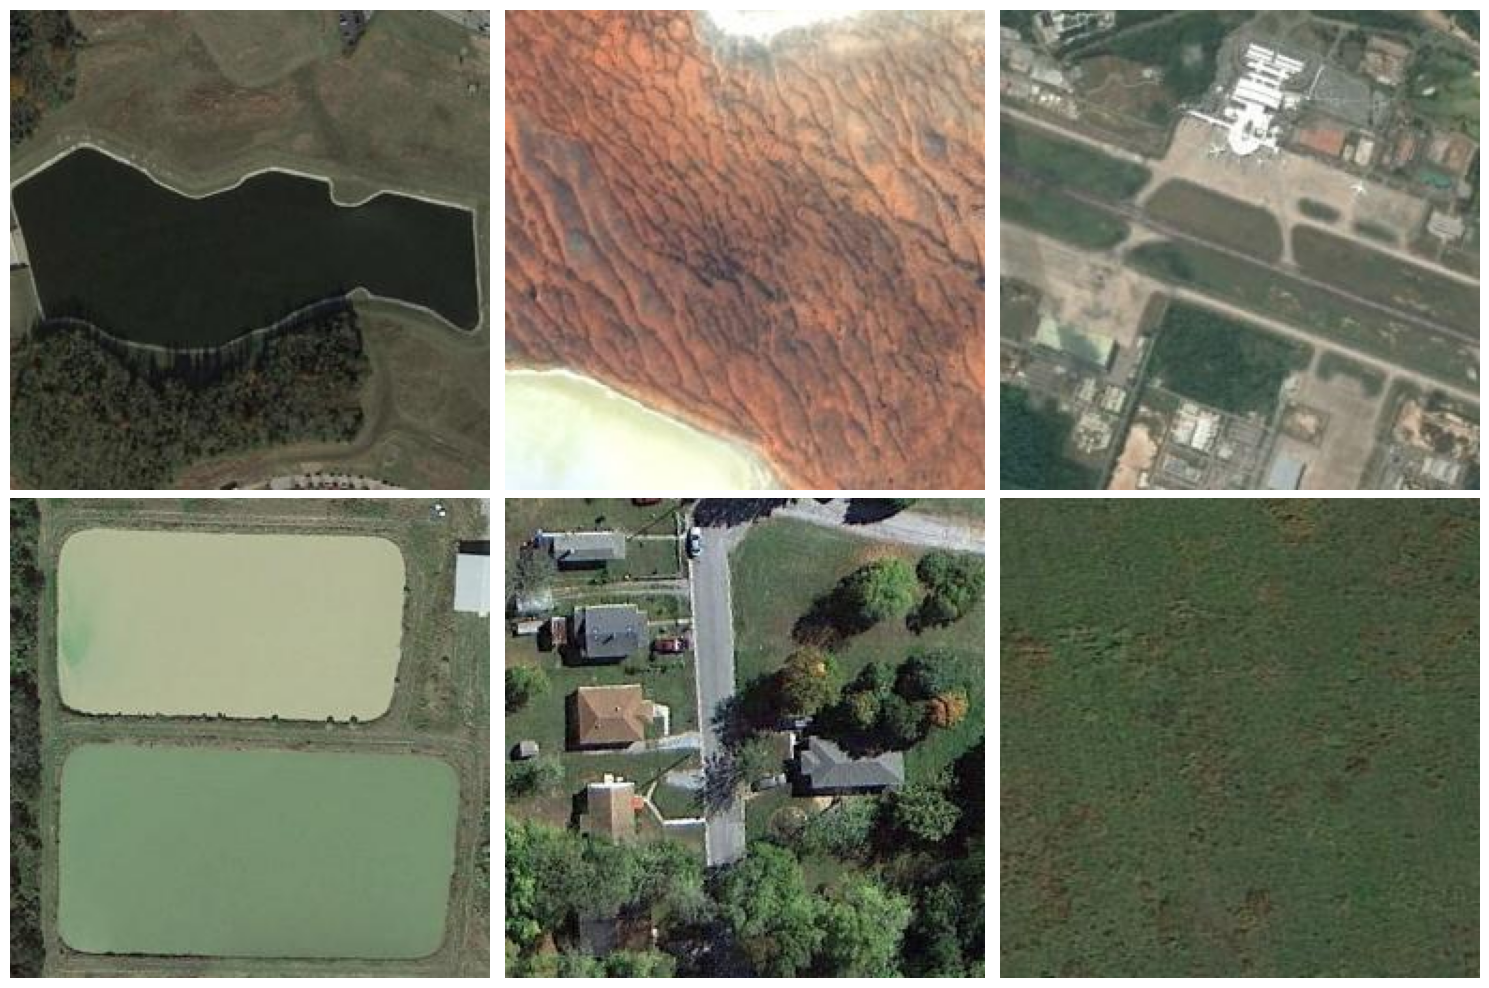

In [3]:
all_images = [
    os.path.join(root, file)
    for root, _, files in os.walk(image_directory)
    for file in files
    if file.lower().endswith(('.jpg', '.jpeg', '.png'))
]

# Select 6 random images
selected_images = random.sample(all_images, 6)

# Plot images in a 2x3 grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
for ax, img_path in zip(axs.ravel(), selected_images):
    ax.imshow(mpimg.imread(img_path))
    ax.axis('off')

plt.tight_layout()
plt.show()

### 🔧 **Function Overview: Train/Validation Dataset Split & Copy**

**Purpose:**
Split a dataset of categorized images (e.g., species or classes) into **train** and **validation** sets based on a defined ratio, then **copy** the images into a structured output directory.

**Steps:**

1. **List Categories:**
   Scan the `image_directory` for subdirectories (one per class/species).

2. **Shuffle & Split:**
   For each class:

   * Randomly shuffle the images.
   * Split them into training and validation subsets based on `train_ratio`.

3. **Prepare Copy Tasks:**

   * Create a list of copy operations (from source to destination paths) for both subsets.

4. **Execute Copying:**

   * For each source–destination pair:

     * Ensure the destination folder exists.
     * Copy the image using `shutil.copyfile`.

> Organized images under `output_dir/train/<class>/...` and `output_dir/val/<class>/...`.


In [4]:
all_tasks = []

for species in [d for d in os.listdir(image_directory) if os.path.isdir(os.path.join(image_directory, d))]:
    species_path = os.path.join(image_directory, species)
    images = os.listdir(species_path)
    random.shuffle(images)
    split = int(len(images) * train_ratio)
    
    for split_name, split_imgs in zip(["train", "val"], [images[:split], images[split:]]):
        for img in split_imgs:
            src = os.path.join(species_path, img)
            dst = os.path.join(output_dir, split_name, species, img)
            all_tasks.append((src, dst))

for src, dst in tqdm(all_tasks, desc="Copying images"):
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)

print("✅ Done splitting into train and val!")

Copying images: 100%|██████████| 12000/12000 [00:15<00:00, 795.54it/s]

✅ Done splitting into train and val!


The transformation pipeline performs the following steps:

* **Resize**: Resizes the image to 224x224 pixels to match the input size expected by most pre-trained models.
* **ToTensor**: Converts the image to a PyTorch tensor, making it compatible with neural network processing.
* **Normalize**: Normalizes the image using the mean (\[0.485, 0.456, 0.406]) and standard deviation (\[0.229, 0.224, 0.225]) values from the ImageNet dataset, ensuring the image is on the same scale as the data the model was trained on.

This pipeline prepares the image for deep learning models by standardizing its size, format, and pixel values.


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),           # Resize to model's expected input size
    transforms.ToTensor(),                   # Convert to PyTorch Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize to match ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

In [6]:
train_dir = "/kaggle/working/data/train"
val_dir = "/kaggle/working/data/val"

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### **Setup model**
This code initializes a pre-trained **ResNet-50** model and modifies its final fully connected layer to match the number of species in the dataset.

* `models.resnet50(pretrained=True)`: Loads the ResNet-50 model with pre-trained weights, which were trained on the ImageNet dataset.
* `model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))`: Replaces the final fully connected layer (`fc`) with a new one. The new layer has the same number of input features (`model.fc.in_features`) but its output size is set to the number of species in the dataset (`len(train_dataset.classes)`).

This ensures that the model’s output layer corresponds to the number of classes (species) in our specific dataset, making it ready for classification tasks.


In [7]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, len(train_dataset.classes))  # auto-detect number of species

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## **Training**

This code performs training and validation of a model, with early stopping based on validation accuracy to prevent overfitting.

### Key Steps:

1. **Epoch Loop**:

   * The loop runs for a specified number of epochs (`num_epochs`). During each epoch, the model is trained and evaluated on validation data.

2. **Training**:

   * The model is set to training mode using `model.train()`.
   * For each batch in the `train_loader`, the model:

     * Computes the predictions and calculates the loss.
     * Performs backpropagation (`loss.backward()`) and updates the weights (`optimizer.step()`).
   * The average training loss for the epoch is computed and printed.

3. **Validation**:

   * The model is set to evaluation mode using `model.eval()`.
   * In this mode, the gradients are turned off (`torch.no_grad()`), and predictions are made for the validation data.
   * The average validation loss and accuracy are computed and printed.

4. **Early Stopping**:

   * The model's validation accuracy is monitored during each epoch.
   * If validation accuracy improves, the model is saved as the "best model" and `trigger_times` is reset.
   * If validation accuracy does not improve for `patience` epochs, early stopping is triggered, and training stops early.

### Key Features:

* **Training Loss**: Monitors the loss during training.
* **Validation Accuracy and Loss**: Measures the model's performance on the validation set.
* **Early Stopping**: Stops training early if there is no improvement in validation accuracy after a specified number of epochs (`patience`).
* **Model Saving**: The best model (with the highest validation accuracy) is saved during training.

This approach ensures that the model doesn’t overfit and only trains as long as necessary to achieve the best validation performance.


In [9]:
from tqdm import tqdm

best_val_acc = 0.0
patience = 3
trigger_times = 0
num_epochs = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"\n🔁 Epoch {epoch+1}/{num_epochs}")
    
    # Training
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc="Training", leave=False)
    
    for inputs, labels in train_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_bar.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)
    print(f"📉 Average training loss: {avg_train_loss:.4f}")
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    val_bar = tqdm(val_loader, desc="Validating", leave=False)

    with torch.no_grad():
        for inputs, labels in val_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = running_val_loss / len(val_loader)
    val_acc = correct / total
    print(f"✅ Validation accuracy: {val_acc:.4f}")
    print(f"📉 Average validation loss: {avg_val_loss:.4f}")

    # Store the average validation loss for this epoch
    val_losses.append(avg_val_loss)

    # Early Stopping Check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
        print(f"💾 New best model saved (val_acc: {val_acc:.4f})")
    else:
        trigger_times += 1
        print(f"⚠️ No improvement. Patience: {trigger_times}/{patience}")

        if trigger_times >= patience:
            print("🛑 Early stopping activated.")
            break



🔁 Epoch 1/20


📉 Average training loss: 0.7192


✅ Validation accuracy: 0.8126
📉 Average validation loss: 0.6088
💾 New best model saved (val_acc: 0.8126)

🔁 Epoch 2/20


📉 Average training loss: 0.3933


✅ Validation accuracy: 0.9219
📉 Average validation loss: 0.2699
💾 New best model saved (val_acc: 0.9219)

🔁 Epoch 3/20


📉 Average training loss: 0.2860


✅ Validation accuracy: 0.9060
📉 Average validation loss: 0.3002
⚠️ No improvement. Patience: 1/3

🔁 Epoch 4/20


📉 Average training loss: 0.2225


✅ Validation accuracy: 0.9581
📉 Average validation loss: 0.1366
💾 New best model saved (val_acc: 0.9581)

🔁 Epoch 5/20


📉 Average training loss: 0.1754


✅ Validation accuracy: 0.9365
📉 Average validation loss: 0.2132
⚠️ No improvement. Patience: 1/3

🔁 Epoch 6/20


📉 Average training loss: 0.1617


✅ Validation accuracy: 0.9681
📉 Average validation loss: 0.1137
💾 New best model saved (val_acc: 0.9681)

🔁 Epoch 7/20


📉 Average training loss: 0.1434


✅ Validation accuracy: 0.9458
📉 Average validation loss: 0.1660
⚠️ No improvement. Patience: 1/3

🔁 Epoch 8/20


📉 Average training loss: 0.1130


✅ Validation accuracy: 0.9653
📉 Average validation loss: 0.1172
⚠️ No improvement. Patience: 2/3

🔁 Epoch 9/20


📉 Average training loss: 0.1117


✅ Validation accuracy: 0.9695
📉 Average validation loss: 0.1001
💾 New best model saved (val_acc: 0.9695)

🔁 Epoch 10/20


📉 Average training loss: 0.0951


✅ Validation accuracy: 0.9163
📉 Average validation loss: 0.3498
⚠️ No improvement. Patience: 1/3

🔁 Epoch 11/20


📉 Average training loss: 0.0927


✅ Validation accuracy: 0.9688
📉 Average validation loss: 0.1067
⚠️ No improvement. Patience: 2/3

🔁 Epoch 12/20


📉 Average training loss: 0.0769


✅ Validation accuracy: 0.9840
📉 Average validation loss: 0.0523
💾 New best model saved (val_acc: 0.9840)

🔁 Epoch 13/20


📉 Average training loss: 0.0663


✅ Validation accuracy: 0.9779
📉 Average validation loss: 0.0705
⚠️ No improvement. Patience: 1/3

🔁 Epoch 14/20


📉 Average training loss: 0.0848


✅ Validation accuracy: 0.9667
📉 Average validation loss: 0.1039
⚠️ No improvement. Patience: 2/3

🔁 Epoch 15/20


📉 Average training loss: 0.0768


✅ Validation accuracy: 0.9772
📉 Average validation loss: 0.0829
⚠️ No improvement. Patience: 3/3
🛑 Early stopping activated.


## **Model Performance**

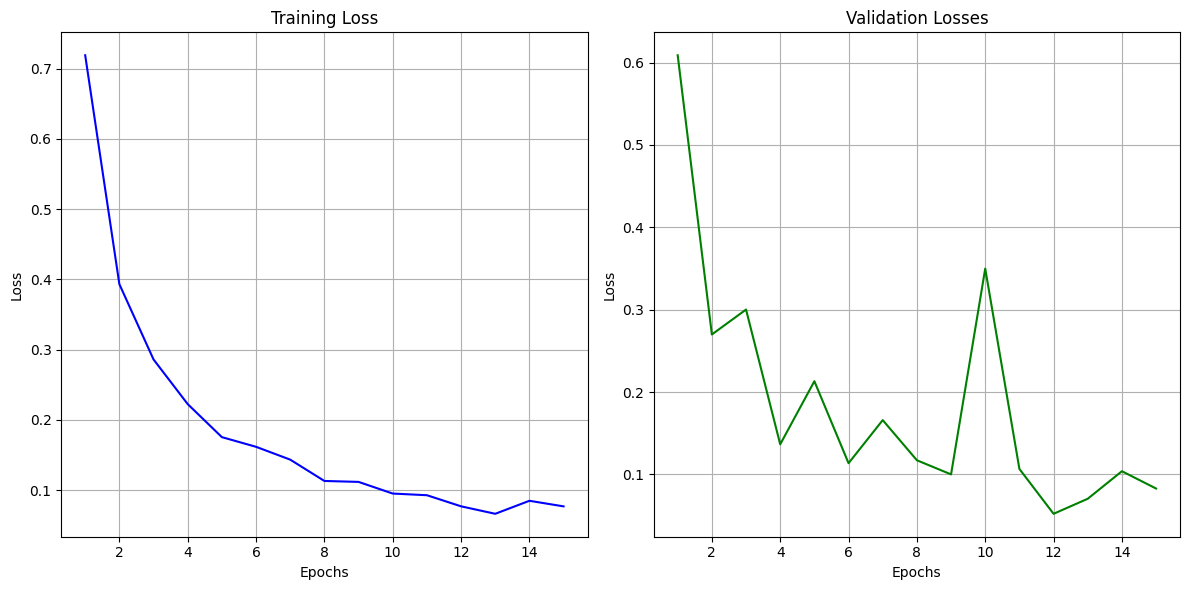

In [10]:
# Plotting the statistics
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", color='blue')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Training Accuracy", color='green')
plt.title("Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()


### **Reload best model**

In [12]:
# Reload your trained model (assuming saved as 'best_model.pth')
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model = model.to(device)

model.eval()  # Set model to evaluation mode

/tmp/ipykernel_91/1051267173.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## **Inferencing**

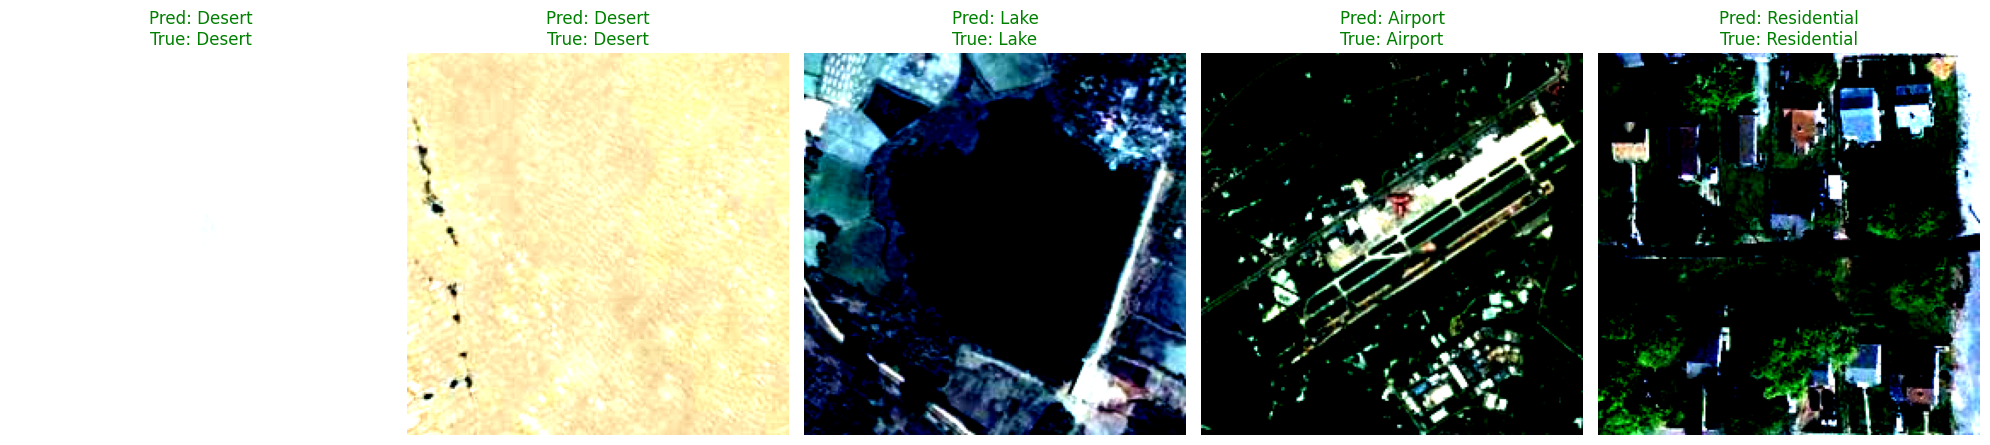

In [14]:
import os
import random
import torch
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# Load validation dataset
val_dataset = datasets.ImageFolder("/kaggle/working/data/val", transform=transform)
class_labels = val_dataset.classes  # GBIF ID folder names

# Select 5 random images
random_indices = random.sample(range(len(val_dataset)), 5)
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, idx in enumerate(random_indices):
    image, true_label_idx = val_dataset[idx]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_input)
    _, pred_idx = torch.max(output, 1)

    predicted_label = class_labels[pred_idx.item()]
    true_label = class_labels[true_label_idx]

    # Color the title green if correct, red if wrong
    is_correct = predicted_label == true_label
    color = 'green' if is_correct else 'red'

    # Display image and result
    axes[i].imshow(image.permute(1, 2, 0).numpy())  # Convert CHW to HWC
    axes[i].set_title(f"Pred: {predicted_label}\nTrue: {true_label}", color=color)
    axes[i].axis('off')

plt.tight_layout()
plt.show()
